In [ ]:
!pip install diffractio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.3/187.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import diffractio
from diffractio import *
import torch
from torchvision.transforms import v2

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from diffractio import degrees, mm, plt, sp, um, np, mm
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.utils_drawing import draw_several_fields
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY



## Light Source

In [ ]:
class resource:
  def __init__(self, Lambda, phase, amplitude):
    self. Lambda =  Lambda
    self.phase = phase
    self.amplitude = amplitude




## Distances

In [ ]:
class distance:
    def __init__(self,z1,z2, Dz):
        self.z1 = z1        #resource to sample distance (can be an array)
        self.z2 = z2        #sample to sensor distance   (can be an array)
        self.Dz = Dz        #distance between heights    (for multi-height phase retreival approach)

## Free Space

In [ ]:
class free_space:
    def __init__(self,  Lambda, numX, numY, z, flag):

        self. Lambda =  Lambda     #source wavelength
        self.numX = numX           #number of samples in fx range (with respect to the shape of data)
        self.numY = numY           #number of samples in fy range (with respect to the shape of data)
        self.z = z                 #distance of propagation
        self.flag = flag           #flag for forward or backward propagation (1: backward, -1:forward)

    def transfer(self):

          fx = np.array(np.linspace(-1/self.Lambda, 1/self.Lambda, self.numX))
          fy = np.array(np.linspace(-1/self.Lambda, 1/self.Lambda, self.numY))
          grid_x, grid_y = np.meshgrid(fx, fy)
          mask = grid_x** 2 +  grid_y** 2 > 1 / self.Lambda**2
          grid_x[mask] = 0
          grid_y[mask] = 0
          fz = np.sqrt((1/(self.Lambda**2))*np.ones(grid_x.shape) - grid_x**2 - grid_y**2)
          H  = np.exp(1j*2*np.pi*self.flag*self.z*fz)
          H[mask] = 0
          return H


## Back Propagation

In [ ]:
def Back_Propagation(z, Lambda, hologram, H):

  return np.fft.ifft2(np.fft.ifftshift(H*np.fft.fftshift(np.fft.fft2(hologram))))


## Forward Propagation

In [ ]:
def Forward_Propagation(z,  Lambda, hologram, H):

  return np.fft.ifft2(np.fft.ifftshift(H*np.fft.fftshift(np.fft.fft2(hologram))))

In [ ]:
def amplitude_update(w1, w2, hologram, frame):
  '''
  weighed sum of measured hologram and calculated hologram with propagation

  '''
  return w1*hologram + w2*frame


In [ ]:
def iterative(level, z,  Lambda, hologram, w1, w2, E, treshold):

  '''
  level : number of different measured height
  z: the distance
  Lambda: wavelength(s) of the source
  hologram : matrix of measured holograms
  w1: weight for measured hologram in amplitude update
  w2: weight for calculated hologram in amplitude update
  E: error threshold
  treshold: treshold of the number of iterations

  '''

  numX, numY = hologram[0, :, :].shape
  s1 = free_space(Lambda, numX, numY, z, -1)
  Hf = s1.transfer()

  s2 = free_space(Lambda, numX, numY, z, 1)
  Hb = s2.transfer()

  frame = hologram[0, :, :]
  phase = 0
  error = 1000
  ERROR = []
  while(treshold > 0):  #np.abs(error) > E and
    for i in range(level):
      for f in Lambda:
         F = Forward_Propagation(z, f, frame, Hf)
         hologram[i, :, :] = np.abs(F)
         frame = amplitude_update(w1, w2, hologram[i+1, :, :], np.abs(F))*np.exp(1j*np.angle(F))


    for i in range(level, 0, -1):
      for f in Lambda:
         B = Back_Propagation(z, f, frame, Hb)
         frame = amplitude_update(w1, w2, hologram[i-1, :, :], np.abs(B))*np.exp(1j*np.angle(B))


    error = np.mean(np.abs(phase - np.angle(frame)))
    ERROR.append(np.abs(error))
    phase = np.angle(frame)

    treshold -= 1

  return phase, frame, ERROR, 200-treshold


## Sample

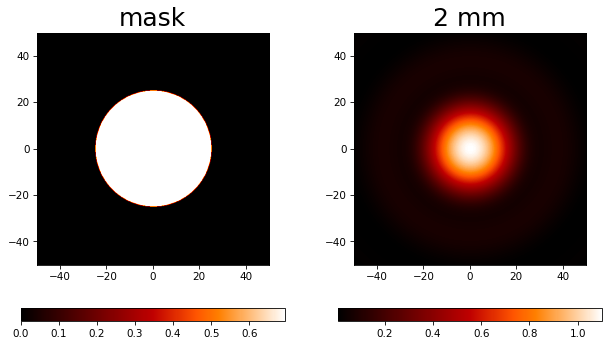

In [ ]:
num_pixels = 512

length = 100 * um
x0 = np.linspace(-length / 2, length / 2, num_pixels)
y0 = np.linspace(-length / 2, length / 2, num_pixels)
wavelength = 0.6238 * um

u1 = Scalar_source_XY(x=x0, y=y0, wavelength=wavelength)
u1.plane_wave(A=1, theta=0 * degrees, phi=0 * degrees)

t1 = Scalar_mask_XY(x=x0, y=y0, wavelength=wavelength)
t1.circle(
    r0=(0 * um, 0 * um), radius=(25 * um, 25 * um), angle=0 * degrees)

u2 = u1 * t1

u3 = u2.RS(z=2 * mm, new_field=True)

#u4 = u2.RS(z=500 * um, new_field=True)

draw_several_fields((u2, u3), titles=('mask', '2 mm'), logarithm=True)

In [ ]:
hologram = np.zeros((2, 512, 512))
hologram[1, :, :] = np.abs(u3.u)
hologram[0, :, :] = np.ones((512, 512))

phase, frame, ERROR, flag = iterative(1, 0.002,  np.array([6.238*1e-7]), hologram, 1, 0, 0.0005, 200)


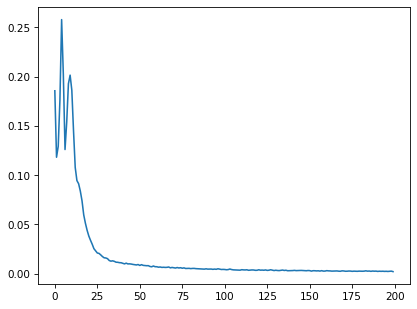

In [ ]:
plt.plot(ERROR)

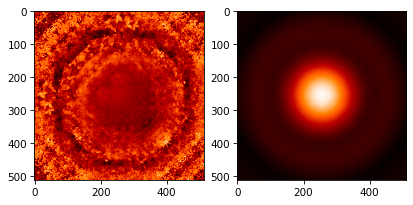

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(np.angle(frame))

plt.subplot(1, 2, 2)
plt.imshow(np.abs(frame))


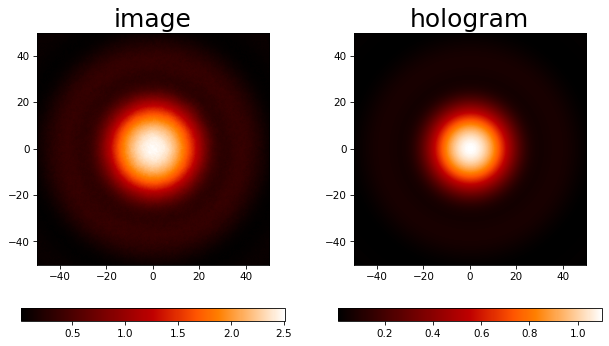

In [ ]:
a = Scalar_source_XY(x=x0, y=y0, wavelength=wavelength)
a.u = frame

draw_several_fields((a, u3), titles=('image', 'hologram'), logarithm=True)

## Super Resolution

In [ ]:
seq = 9   #number of digitally shifted LR samples
step = 2  #pixels to shift
scale = 5 #down sampling factor
h, w = img.shape

angle = [0, 30, 60, 90, 120, 180]
for t in angle:
  transforms = v2.compose([
      v2.RandomAffine(degrees = 0, translate = (step, step)),
      v2.GaussianBlur(5, sigma=np.sqrt(2)),
      v2.Resize((h/scale, w/scale)),
      v2.RandomRotation(t),

      v2.RandomHorizontalFlip(p=0.5),
      v2.RandomVerticalFlip(p=0.5)


   ])
